In [1]:
library(xgboost)
library(readr)
library(stringr)
library(caret)
library(car)
library(DMwR)
library(Hmisc)
library(plyr)
library(dplyr)
library(tidyr)
library(data.table)
library(DescTools)
library(Matrix)
library(glmnet)
library(plotrix)

options(warn=-1)

set.seed(0)
setwd("C:/Users/Jeane/MSDS/Proj2")
# load data
df_train = read_csv("C:/Users/Jeane/MSDS/Proj2/airbnb/train_users_2.csv")
df_test = read_csv("C:/Users/Jeane/MSDS/Proj2/airbnb/test_users.csv")
age_gender_bkts <- fread("C:/Users/Jeane/MSDS/Proj2/airbnb/age_gender_bkts.csv", data.table=F)
countries <- fread("C:/Users/Jeane/MSDS/Proj2/airbnb/countries.csv", data.table=F)
sample_submission_NDF <- fread("C:/Users/Jeane/MSDS/Proj2/airbnb/sample_submission_NDF.csv", data.table=F)
sessions <- fread("C:/Users/Jeane/MSDS/Proj2/airbnb/sessions.csv", data.table=F)
summary(df_train)

Loading required package: lattice
Loading required package: ggplot2
Loading required package: carData
Loading required package: grid
Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:caret':

    cluster

Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units


Attaching package: 'plyr'

The following objects are masked from 'package:Hmisc':

    is.discrete, summarize

The following object is masked from 'package:DMwR':

    join


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:Hmisc':

    src, summarize

The following object is masked from 'package:car':

    recode

The following object is masked from 'package:xgboost':

    slice

The following objects are masked from 'pack

      id            date_account_created timestamp_first_active
 Length:213451      Min.   :2010-01-01   Min.   :2.009e+13     
 Class :character   1st Qu.:2012-12-26   1st Qu.:2.012e+13     
 Mode  :character   Median :2013-09-11   Median :2.013e+13     
                    Mean   :2013-06-25   Mean   :2.013e+13     
                    3rd Qu.:2014-03-06   3rd Qu.:2.014e+13     
                    Max.   :2014-06-30   Max.   :2.014e+13     
                                                               
 date_first_booking      gender               age          signup_method     
 Min.   :2010-01-02   Length:213451      Min.   :   1.00   Length:213451     
 1st Qu.:2012-12-02   Class :character   1st Qu.:  28.00   Class :character  
 Median :2013-09-11   Mode  :character   Median :  34.00   Mode  :character  
 Mean   :2013-07-04                      Mean   :  49.67                     
 3rd Qu.:2014-04-04                      3rd Qu.:  43.00                     
 Max.   :2015-06-29 

In [2]:
labels = df_train[, c('id', 'country_destination')]
df_test$country_destination = NA
str(df_test)

Classes 'tbl_df', 'tbl' and 'data.frame':	62096 obs. of  16 variables:
 $ id                     : chr  "5uwns89zht" "jtl0dijy2j" "xx0ulgorjt" "6c6puo6ix0" ...
 $ date_account_created   : Date, format: "2014-07-01" "2014-07-01" ...
 $ timestamp_first_active : num  2.01e+13 2.01e+13 2.01e+13 2.01e+13 2.01e+13 ...
 $ date_first_booking     : logi  NA NA NA NA NA NA ...
 $ gender                 : chr  "FEMALE" "-unknown-" "-unknown-" "-unknown-" ...
 $ age                    : num  35 NA NA NA NA 28 48 NA NA NA ...
 $ signup_method          : chr  "facebook" "basic" "basic" "basic" ...
 $ signup_flow            : num  0 0 0 0 0 0 25 0 0 0 ...
 $ language               : chr  "en" "en" "en" "en" ...
 $ affiliate_channel      : chr  "direct" "direct" "direct" "direct" ...
 $ affiliate_provider     : chr  "direct" "direct" "direct" "direct" ...
 $ first_affiliate_tracked: chr  "untracked" "untracked" "linked" "linked" ...
 $ signup_app             : chr  "Moweb" "Moweb" "Web" "Web" ...
 $ f

In [11]:
str(labels)

Classes 'tbl_df', 'tbl' and 'data.frame':	213451 obs. of  2 variables:
 $ id                 : chr  "gxn3p5htnn" "820tgsjxq7" "4ft3gnwmtx" "bjjt8pjhuk" ...
 $ country_destination: chr  "NDF" "NDF" "US" "other" ...


In [17]:
# combine train and test data
df_train$dataset <- "train"
df_test$dataset <- "test"
df_all = rbind(df_train, df_test)
print(dim(df_train))
print(dim(df_test))
print(dim(df_all))

[1] 213451     17
[1] 62096    17
[1] 275547     17


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00   28.00   33.00   47.15   42.00 2014.00  116866 


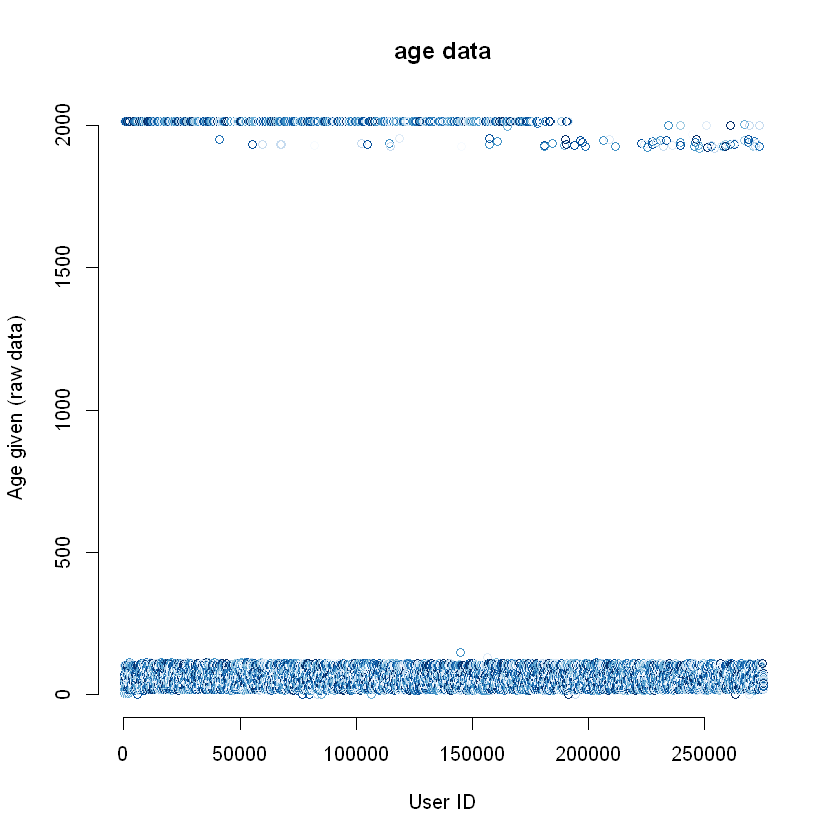

In [106]:
par(bty="n")
plot(df_all$age, main="age data",
     ylab = "Age given (raw data)", xlab="User ID", col=blues9)

print(summary(df_all$age))


In [28]:
#what does the kaggle age/gender brackets look like
print(head(age_gender_bkts))
print(tail(age_gender_bkts))

  age_bucket country_destination gender population_in_thousands year
1       100+                  AU   male                       1 2015
2      95-99                  AU   male                       9 2015
3      90-94                  AU   male                      47 2015
4      85-89                  AU   male                     118 2015
5      80-84                  AU   male                     199 2015
6      75-79                  AU   male                     298 2015
    age_bucket country_destination gender population_in_thousands year
415       100+                  US   male                      13 2015
416      95-99                  US   male                     115 2015
417      90-94                  US   male                     541 2015
418      15-19                  US female                   10570 2015
419      85-89                  US   male                    1441 2015
420      80-84                  US   male                    2442 2015


## Cleaning the age data

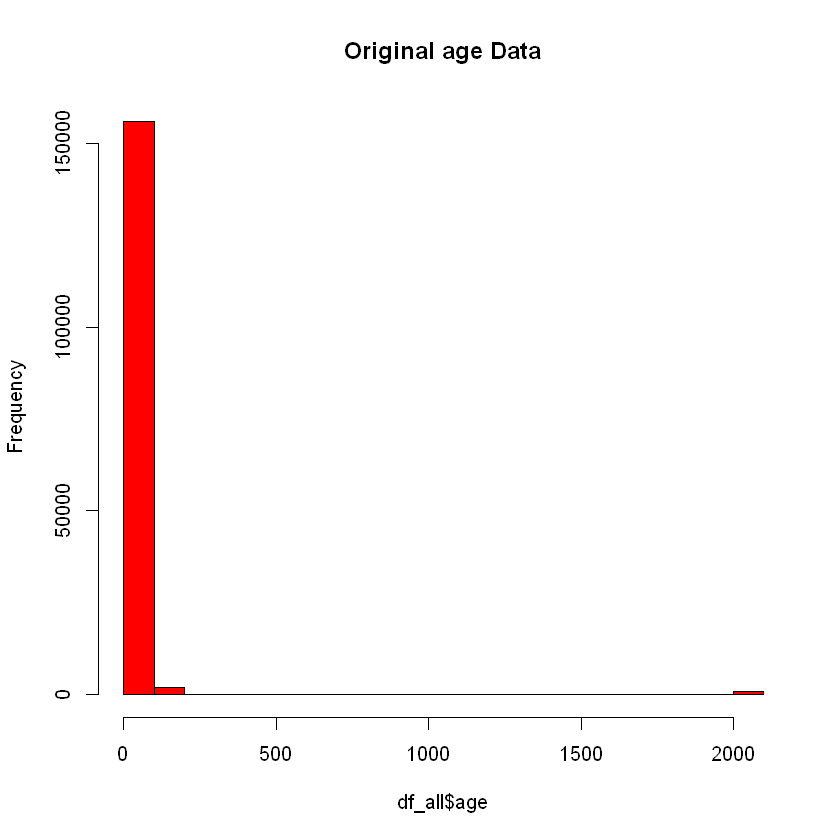

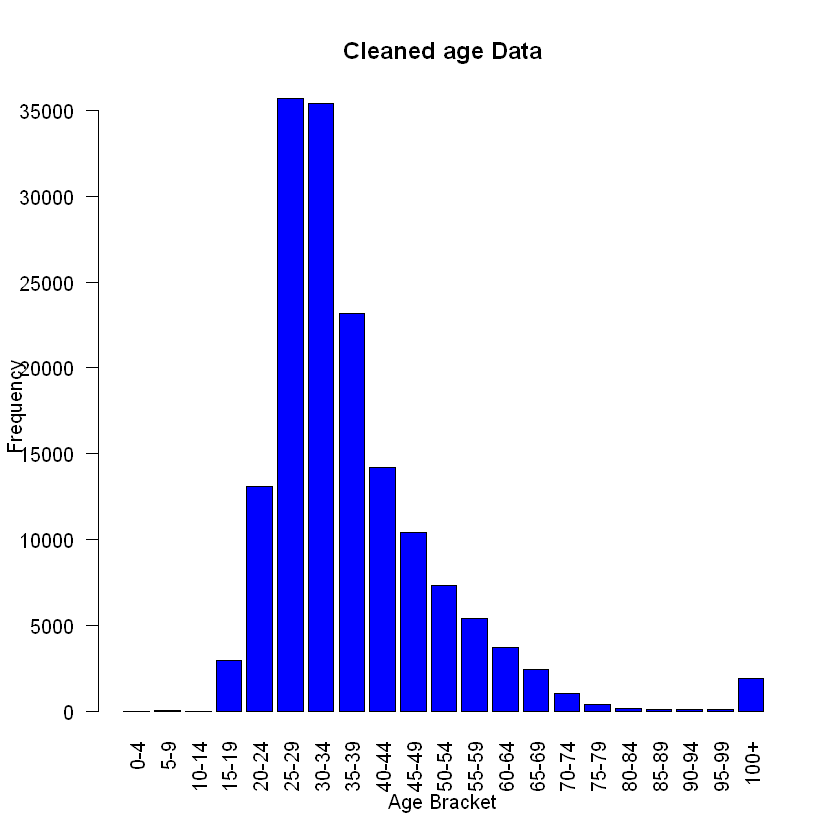

In [45]:
df_all <- df_all %>%
  dplyr::mutate(
    age_cln = ifelse(age >= 1920, 2015 - age, age),
    age_cln2 = ifelse(age_cln < 14 | age_cln > 100, -1, age_cln),
    age_bucket = cut(age, breaks = c(min(age_cln, na.rm=TRUE),
                                     4, 9, 14, 19, 24,
                                     29, 34, 39, 44, 49, 54,
                                     59, 64, 69, 74, 79, 84,
                                     89, 94, 99, max(age_cln, na.rm=TRUE)
    )),
    age_bucket = mapvalues(age_bucket,
                           from=c("(1,4]", "(4,9]", "(9,14]", "(14,19]",
                                  "(19,24]", "(24,29]", "(29,34]", "(34,39]",
                                  "(39,44]", "(44,49]", "(49,54]", "(54,59]",
                                  "(59,64]", "(64,69]", "(69,74]", "(74,79]",
                                  "(79,84]", "(84,89]", "(89,94]", "(94,99]", "(99,150]"),
                           to=c("0-4", "5-9", "10-14", "15-19",
                                "20-24", "25-29", "30-34", "35-39",
                                "40-44", "45-49", "50-54", "55-59",
                                "60-64", "65-69", "70-74", "75-79",
                                "80-84", "85-89", "90-94", "95-99", "100+"))
  )
hist(df_all$age, main="Original age Data", col="red")
plot(df_all$age_bucket, main="Cleaned age Data", 
     ylab="Frequency",
     xlab="Age Bracket",
    col="blue",
    las=2, cex.lab=1, cex.axis=1, font=1,col.axis="black")

In [167]:
age_gender_bkts <- age_gender_bkts %>%
  dplyr::left_join(., countries, by = "country_destination")

In [168]:
age_gender_bkts <- age_gender_bkts[c("age_bucket", "country_destination",
                                     "gender", "population_in_thousands",
                                     "year", "destination_language")]

In [169]:
age_gender_bkts <- dplyr::mutate(age_gender_bkts,
                                 country_language = paste0(country_destination,
                                                           "_", destination_language))

In [176]:
age_gender_bkts_reshape <- data.frame()
for(i in unique(age_gender_bkts$country_language)){
  # i <- "AU_eng"
  age_gender_bkts_ <- subset(age_gender_bkts, country_language == i)
  age_gender_bkts_$country_language <- NULL
  age_gender_bkts_ <- reshape(age_gender_bkts_,
                              direction='wide',
                              idvar=c('destination_language', 'age_bucket',
                                      'gender', 'year'),
                              timevar='country_destination')
  age_gender_bkts_reshape <- bind_rows(
    age_gender_bkts_reshape,
    age_gender_bkts_
  )
}

In [179]:
age_gender_bkts_reshape$year <- NULL
age_gender_bkts_reshape <- age_gender_bkts_reshape %>%
  dplyr::mutate(.,
                gender = toupper(gender),
                language = str_sub(destination_language, 1, 2)
  ) %>%
  dplyr::select(-destination_language) %>%
  dplyr::group_by(age_bucket, gender, language) %>%
  dplyr::summarise_all(funs(Sum))

In [180]:
df_all_age_gender_bkts_feats <- dplyr::left_join(df_all[c("id", "age_bucket", "gender", "language")],
                                                 age_gender_bkts_reshape,
                                                 by = c("age_bucket", "gender", "language"))

In [181]:
df_all_age_gender_bkts_feats$age_bucket <- NULL
df_all_age_gender_bkts_feats$gender <- NULL
df_all_age_gender_bkts_feats$language <- NULL
df_all_age_gender_bkts_feats <- melt.data.table(as.data.table(df_all_age_gender_bkts_feats))
df_all_age_gender_bkts_feats <- data.frame(df_all_age_gender_bkts_feats)
names(df_all_age_gender_bkts_feats) <- c("id", "feature", "value")
print("age_gender_bkts feature")
print(n_distinct(df_all_age_gender_bkts_feats$feature))

[1] "age_gender_bkts feature"
[1] 10


In [184]:
summary(df_all_age_gender_bkts_feats)
head(df_all_age_gender_bkts_feats)
tail(df_all_age_gender_bkts_feats)

      id                                  feature            value        
 Length:2755470     population_in_thousands.AU: 275547   Min.   :    0    
 Class :character   population_in_thousands.CA: 275547   1st Qu.:    0    
 Mode  :character   population_in_thousands.DE: 275547   Median :    0    
                    population_in_thousands.ES: 275547   Mean   : 1451    
                    population_in_thousands.FR: 275547   3rd Qu.: 1220    
                    population_in_thousands.GB: 275547   Max.   :11601    
                    (Other)                   :1102188   NA's   :1437580  

id,feature,value
gxn3p5htnn,population_in_thousands.AU,NA
820tgsjxq7,population_in_thousands.AU,797
4ft3gnwmtx,population_in_thousands.AU,739
bjjt8pjhuk,population_in_thousands.AU,838
87mebub9p4,population_in_thousands.AU,NA
osr2jwljor,population_in_thousands.AU,NA


,id,feature,value
2755465,8yvhec201j,population_in_thousands.US,NA
2755466,cv0na2lf5a,population_in_thousands.US,NA
2755467,zp8xfonng8,population_in_thousands.US,NA
2755468,fa6260ziny,population_in_thousands.US,NA
2755469,87k0fy4ugm,population_in_thousands.US,NA
2755470,9uqfg8txu3,population_in_thousands.US,10659


## Examine dates associated with users

In [50]:
#format of dates
str(df_all$date_first_booking)
str(df_all$date_account_created)
str(df_all$timestamp_first_active)


 Date[1:275547], format: NA NA "2010-08-02" "2012-09-08" "2010-02-18" "2010-01-02" ...
 Date[1:275547], format: "2010-06-28" "2011-05-25" "2010-09-28" "2011-12-05" "2010-09-14" ...
 num [1:275547] 2.01e+13 2.01e+13 2.01e+13 2.01e+13 2.01e+13 ...


In [48]:
# Disect information about account dates
# calculate differences between creation, first active, and booking
df_all <- df_all %>%
  separate(date_account_created, into = c("dac_year", "dac_month", "dac_day"), sep = "-", remove=FALSE) %>%
  dplyr::mutate(
    dac_yearmonth = paste0(dac_year, dac_month),
    dac_yearmonthday = as.numeric(paste0(dac_year, dac_month, dac_day)),
    dac_week = as.numeric(format(date_account_created+3, "%U")),
    dac_yearmonthweek = as.numeric(paste0(dac_year, dac_month, formatC(dac_week, width=2, flag="0"))),
    tfa_year = str_sub(timestamp_first_active, 1, 4),
    tfa_month = str_sub(timestamp_first_active, 5, 6),
    tfa_day = str_sub(timestamp_first_active, 7, 8),
    tfa_yearmonth = str_sub(timestamp_first_active, 1, 6),
    tfa_yearmonthday = as.numeric(str_sub(timestamp_first_active, 1, 8)),
    tfa_date = as.Date(paste(tfa_year, tfa_month, tfa_day, sep="-")),
    tfa_week = as.numeric(format(tfa_date+3, "%U")),
    tfa_yearmonthweek = as.numeric(paste0(tfa_year, tfa_month, formatC(tfa_week, width=2, flag="0"))),
    dac_lag = as.numeric(date_account_created - tfa_date),
    dfb_dac_lag = as.numeric(date_first_booking - date_account_created),
    dfb_dac_lag_cut = as.character(cut2(dfb_dac_lag, c(0, 1))),
    dfb_dac_lag_flg = as.numeric(as.factor(ifelse(is.na(dfb_dac_lag_cut)==T, "NA", dfb_dac_lag_cut))) - 1,
    dfb_tfa_lag = as.numeric(date_first_booking - tfa_date),
    dfb_tfa_lag_cut = as.character(cut2(dfb_tfa_lag, c(0, 1))),
    dfb_tfa_lag_flg = as.numeric(as.factor(ifelse(is.na(dfb_tfa_lag_cut)==T, "NA", dfb_tfa_lag_cut))) - 1
  )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-349.00    1.00    3.00   44.36   29.00  365.00  186639 


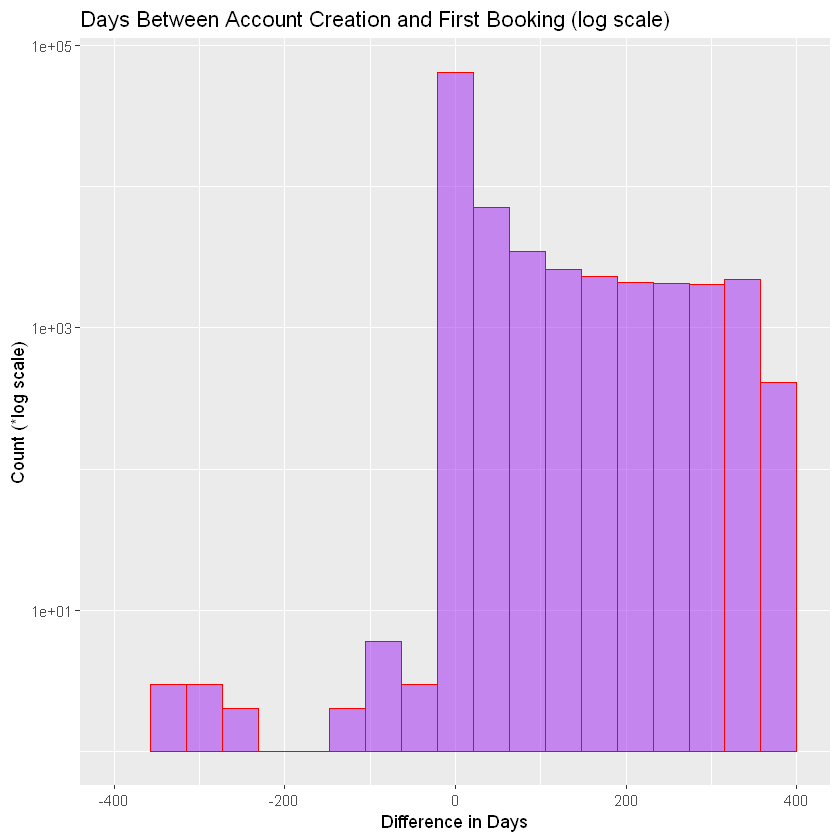

In [83]:
print(summary(df_all$dfb_dac_lag))
ggplot(df_all,aes(x = dfb_dac_lag)) + 
geom_histogram(bins=20,
              col="red",
              fill="purple",
              alpha = .5) + 
scale_y_log10() +
labs(title="Days Between Account Creation and First Booking (log scale)",
     y="Count (*log scale)",
     x="Difference in Days") +
xlim(c(-400,400))



## Examine information in "Countries" data
##### summary statistics of destination countries in this dataset and their locations

In [85]:
str(countries)

'data.frame':	10 obs. of  7 variables:
 $ country_destination          : chr  "AU" "CA" "DE" "ES" ...
 $ lat_destination              : num  -26.9 62.4 51.2 39.9 46.2 ...
 $ lng_destination              : num  133.28 -96.82 10.45 -2.49 2.21 ...
 $ distance_km                  : num  15298 2828 7880 7731 7683 ...
 $ destination_km2              : num  7741220 9984670 357022 505370 643801 ...
 $ destination_language         : chr  "eng" "eng" "deu" "spa" ...
 $ language_levenshtein_distance: num  0 0 72.6 92.2 92.1 ...


In [86]:
countries <- dplyr::mutate(countries,
                           language = str_sub(destination_language, 1, 2))
df_all <- df_all %>%
  dplyr::mutate(country_destination = country_destination) %>%
  dplyr::left_join(., countries[c("language", "country_destination", "distance_km", "destination_km2", "language_levenshtein_distance")],
                   by = c("language", "country_destination"))
countries$language <- NULL

In [94]:
dim(df_all)

str(df_all)

[1] 275547     45

Classes 'tbl_df', 'tbl' and 'data.frame':	275547 obs. of  45 variables:
 $ id                           : chr  "gxn3p5htnn" "820tgsjxq7" "4ft3gnwmtx" "bjjt8pjhuk" ...
 $ date_account_created         : Date, format: "2010-06-28" "2011-05-25" ...
 $ dac_year                     : chr  "2010" "2011" "2010" "2011" ...
 $ dac_month                    : chr  "06" "05" "09" "12" ...
 $ dac_day                      : chr  "28" "25" "28" "05" ...
 $ timestamp_first_active       : num  2.01e+13 2.01e+13 2.01e+13 2.01e+13 2.01e+13 ...
 $ date_first_booking           : Date, format: NA NA ...
 $ gender                       : chr  "-unknown-" "MALE" "FEMALE" "FEMALE" ...
 $ age                          : num  NA 38 56 42 41 NA 46 47 50 46 ...
 $ signup_method                : chr  "facebook" "facebook" "basic" "facebook" ...
 $ signup_flow                  : num  0 0 3 0 0 0 0 0 0 0 ...
 $ language                     : chr  "en" "en" "en" "en" ...
 $ affiliate_channel            : chr  "direct" "

## We have now increased the features from 17 to 45

In [148]:
countries <- dplyr::mutate(countries,
                           country_language = paste0(country_destination, "_", destination_language))

In [149]:
countries_reshape <- data.frame()
for(i in unique(countries$country_language)){
  # i <- "AU_eng"
  countries_ <- subset(countries, country_language == i)
  countries_$country_language <- NULL
  countries_ <- reshape(countries_,
                        direction='wide',
                        idvar='destination_language',
                        timevar='country_destination')
  countries_reshape <- bind_rows(
    countries_reshape,
    countries_
  )
}

In [154]:
Sum <- function(x) sum(x, na.rm=TRUE)

In [159]:
countries_reshape <- countries_reshape %>%
  dplyr::group_by(destination_language) %>%
  dplyr::summarise_all(funs(Sum))


In [160]:
countries_reshape <- dplyr::mutate(countries_reshape,
                                   destination_language = str_sub(destination_language, 1, 2))

In [161]:
df_all_countries_feats <- dplyr::left_join(df_all[c("id", "language")],
                                           countries_reshape,
                                           by = c("language" = "destination_language"))

In [162]:
df_all_countries_feats$language <- NULL
df_all_countries_feats <- melt.data.table(as.data.table(df_all_countries_feats))
df_all_countries_feats <- data.frame(df_all_countries_feats)
names(df_all_countries_feats) <- c("id", "feature", "value")
print("countries feature")
print(n_distinct(df_all_countries_feats$feature))

[1] "countries feature"
[1] 50


In [165]:
summary(df_all_countries_feats)
head(df_all_countries_feats)
tail(df_all_countries_feats)

      id                                        feature        
 Length:13777350    lat_destination.AU              :  275547  
 Class :character   lng_destination.AU              :  275547  
 Mode  :character   distance_km.AU                  :  275547  
                    destination_km2.AU              :  275547  
                    language_levenshtein_distance.AU:  275547  
                    lat_destination.CA              :  275547  
                    (Other)                         :12124068  
     value        
 Min.   :    -97  
 1st Qu.:      0  
 Median :      0  
 Mean   : 549808  
 3rd Qu.:      0  
 Max.   :9984670  
 NA's   :337850   

id,feature,value
gxn3p5htnn,lat_destination.AU,-26.85339
820tgsjxq7,lat_destination.AU,-26.85339
4ft3gnwmtx,lat_destination.AU,-26.85339
bjjt8pjhuk,lat_destination.AU,-26.85339
87mebub9p4,lat_destination.AU,-26.85339
osr2jwljor,lat_destination.AU,-26.85339


,id,feature,value
13777345,8yvhec201j,language_levenshtein_distance.US,0
13777346,cv0na2lf5a,language_levenshtein_distance.US,0
13777347,zp8xfonng8,language_levenshtein_distance.US,NA
13777348,fa6260ziny,language_levenshtein_distance.US,0
13777349,87k0fy4ugm,language_levenshtein_distance.US,0
13777350,9uqfg8txu3,language_levenshtein_distance.US,0


# Now Disect Sessions information

In [107]:
str(sessions)

'data.frame':	10567737 obs. of  6 variables:
 $ user_id      : chr  "d1mm9tcy42" "d1mm9tcy42" "d1mm9tcy42" "d1mm9tcy42" ...
 $ action       : chr  "lookup" "search_results" "lookup" "search_results" ...
 $ action_type  : chr  "" "click" "" "click" ...
 $ action_detail: chr  "" "view_search_results" "" "view_search_results" ...
 $ device_type  : chr  "Windows Desktop" "Windows Desktop" "Windows Desktop" "Windows Desktop" ...
 $ secs_elapsed : num  319 67753 301 22141 435 ...


In [108]:
sessions$flg <- 1
sessions <- data.table(sessions)
sessions[, seq := sequence(.N), by = c("user_id")]
sessions[, seq_rev := rev(sequence(.N)), by = c("user_id")]
sessions[, action2 := paste(action, action_type, action_detail, device_type, sep="_"),]


In [109]:
str(sessions)

Classes 'data.table' and 'data.frame':	10567737 obs. of  10 variables:
 $ user_id      : chr  "d1mm9tcy42" "d1mm9tcy42" "d1mm9tcy42" "d1mm9tcy42" ...
 $ action       : chr  "lookup" "search_results" "lookup" "search_results" ...
 $ action_type  : chr  "" "click" "" "click" ...
 $ action_detail: chr  "" "view_search_results" "" "view_search_results" ...
 $ device_type  : chr  "Windows Desktop" "Windows Desktop" "Windows Desktop" "Windows Desktop" ...
 $ secs_elapsed : num  319 67753 301 22141 435 ...
 $ flg          : num  1 1 1 1 1 1 1 1 1 1 ...
 $ seq          : int  1 2 3 4 5 6 7 8 9 10 ...
 $ seq_rev      : int  127 126 125 124 123 122 121 120 119 118 ...
 $ action2      : chr  "lookup___Windows Desktop" "search_results_click_view_search_results_Windows Desktop" "lookup___Windows Desktop" "search_results_click_view_search_results_Windows Desktop" ...
 - attr(*, ".internal.selfref")=<externalptr> 


#### Engineering sessions logs for user ID's
- Use melt.data.table function to melt multiple session information columns 
- Use saveRDS to save the reshaped objects
- Credit: Found fixes and tips on stackoverflow and github
### Looks like a lot of code, but using copy & paste along with find & replace makes it go fast

In [111]:
getwd()

[1] "C:/Users/Jeane/MSDS/Proj2"

In [ ]:
#create a cache directory to save melted R datafiles
dir.create("cache")


In [114]:
#Use find and replace on copies of the same block of code
#all the different categories to sum and find mind mean
first_execution <- 1

if(first_execution == 1){
  sessions_action_se_sum <- sessions[,list(secs_elapsed_sum = sum(secs_elapsed, na.rm=T)),
                                     by=list(user_id, action)]
  sessions_action_se_sum <- melt.data.table(sessions_action_se_sum)
  sessions_action_se_sum$variable <- NULL
  sessions_action_se_sum <- data.frame(sessions_action_se_sum)
  names(sessions_action_se_sum) <- c("id", "feature", "value")
  sessions_action_se_sum$feature <- paste("action_se_sum", sessions_action_se_sum$feature, sep="_")
  n_distinct(sessions_action_se_sum$feature)
  saveRDS(sessions_action_se_sum, "cache/sessions_action_se_sum.RData")
  
  
  sessions_action_type_se_sum <- sessions[,list(secs_elapsed_sum = sum(secs_elapsed, na.rm=T)),
                                          by=list(user_id, action_type)]
  sessions_action_type_se_sum <- melt.data.table(sessions_action_type_se_sum)
  sessions_action_type_se_sum$variable <- NULL
  sessions_action_type_se_sum <- data.frame(sessions_action_type_se_sum)
  names(sessions_action_type_se_sum) <- c("id", "feature", "value")
  sessions_action_type_se_sum$feature <- paste("action_type_se_sum", sessions_action_type_se_sum$feature, sep="_")
  n_distinct(sessions_action_type_se_sum$feature)
  saveRDS(sessions_action_type_se_sum, "cache/sessions_action_type_se_sum.RData")
  
  
  sessions_action_detail_se_sum <- sessions[,list(secs_elapsed_sum = sum(secs_elapsed, na.rm=T)),
                                            by=list(user_id, action_detail)]
  sessions_action_detail_se_sum <- melt.data.table(sessions_action_detail_se_sum)
  sessions_action_detail_se_sum$variable <- NULL
  sessions_action_detail_se_sum <- data.frame(sessions_action_detail_se_sum)
  names(sessions_action_detail_se_sum) <- c("id", "feature", "value")
  sessions_action_detail_se_sum$feature <- paste("action_detail_se_sum", sessions_action_detail_se_sum$feature, sep="_")
  n_distinct(sessions_action_detail_se_sum$feature)
  saveRDS(sessions_action_detail_se_sum, "cache/sessions_action_detail_se_sum.RData")
  
  
  sessions_device_type_se_sum <- sessions[,list(secs_elapsed_sum = sum(secs_elapsed, na.rm=T)),
                                          by=list(user_id, device_type)]
  sessions_device_type_se_sum <- melt.data.table(sessions_device_type_se_sum)
  sessions_device_type_se_sum$variable <- NULL
  sessions_device_type_se_sum <- data.frame(sessions_device_type_se_sum)
  names(sessions_device_type_se_sum) <- c("id", "feature", "value")
  sessions_device_type_se_sum$feature <- paste("device_type_se_sum", sessions_device_type_se_sum$feature, sep="_")
  n_distinct(sessions_device_type_se_sum$feature)
  saveRDS(sessions_device_type_se_sum, "cache/sessions_device_type_se_sum.RData")
  
  
  sessions_action_flg_sum <- sessions[,list(flg_sum = sum(flg, na.rm=T)),
                                      by=list(user_id, action)]
  sessions_action_flg_sum <- melt.data.table(sessions_action_flg_sum)
  sessions_action_flg_sum$variable <- NULL
  sessions_action_flg_sum <- data.frame(sessions_action_flg_sum)
  names(sessions_action_flg_sum) <- c("id", "feature", "value")
  sessions_action_flg_sum$feature <- paste("action_flg_sum", sessions_action_flg_sum$feature, sep="_")
  n_distinct(sessions_action_flg_sum$feature)
  saveRDS(sessions_action_flg_sum, "cache/sessions_action_flg_sum.RData")
  
  
  sessions_action_type_flg_sum <- sessions[,list(flg_sum = sum(flg, na.rm=T)),
                                           by=list(user_id, action_type)]
  sessions_action_type_flg_sum <- melt.data.table(sessions_action_type_flg_sum)
  sessions_action_type_flg_sum$variable <- NULL
  sessions_action_type_flg_sum <- data.frame(sessions_action_type_flg_sum)
  names(sessions_action_type_flg_sum) <- c("id", "feature", "value")
  sessions_action_type_flg_sum$feature <- paste("action_type_flg_sum", sessions_action_type_flg_sum$feature, sep="_")
  n_distinct(sessions_action_type_flg_sum$feature)
  saveRDS(sessions_action_type_flg_sum, "cache/sessions_action_type_flg_sum.RData")
  
  
  sessions_action_detail_flg_sum <- sessions[,list(flg_sum = sum(flg, na.rm=T)),
                                             by=list(user_id, action_detail)]
  sessions_action_detail_flg_sum <- melt.data.table(sessions_action_detail_flg_sum)
  sessions_action_detail_flg_sum$variable <- NULL
  sessions_action_detail_flg_sum <- data.frame(sessions_action_detail_flg_sum)
  names(sessions_action_detail_flg_sum) <- c("id", "feature", "value")
  sessions_action_detail_flg_sum$feature <- paste("action_detail_flg_sum", sessions_action_detail_flg_sum$feature, sep="_")
  n_distinct(sessions_action_detail_flg_sum$feature)
  saveRDS(sessions_action_detail_flg_sum, "cache/sessions_action_detail_flg_sum.RData")
  
  
  sessions_device_type_flg_sum <- sessions[,list(flg_sum = sum(flg, na.rm=T)),
                                           by=list(user_id, device_type)]
  sessions_device_type_flg_sum <- melt.data.table(sessions_device_type_flg_sum)
  sessions_device_type_flg_sum$variable <- NULL
  sessions_device_type_flg_sum <- data.frame(sessions_device_type_flg_sum)
  names(sessions_device_type_flg_sum) <- c("id", "feature", "value")
  sessions_device_type_flg_sum$feature <- paste("device_type_flg_sum", sessions_device_type_flg_sum$feature, sep="_")
  n_distinct(sessions_device_type_flg_sum$feature)
  saveRDS(sessions_device_type_flg_sum, "cache/sessions_device_type_flg_sum.RData")
  
  
  sessions_action_se_mean <- sessions[,list(secs_elapsed_mean = mean(secs_elapsed, na.rm=T)),
                                      by=list(user_id, action)]
  sessions_action_se_mean <- melt.data.table(sessions_action_se_mean)
  sessions_action_se_mean$variable <- NULL
  sessions_action_se_mean <- data.frame(sessions_action_se_mean)
  names(sessions_action_se_mean) <- c("id", "feature", "value")
  sessions_action_se_mean$feature <- paste("action_se_mean", sessions_action_se_mean$feature, sep="_")
  n_distinct(sessions_action_se_mean$feature)
  saveRDS(sessions_action_se_mean, "cache/sessions_action_se_mean.RData")
  
  
  sessions_action_type_se_mean <- sessions[,list(secs_elapsed_mean = mean(secs_elapsed, na.rm=T)),
                                           by=list(user_id, action_type)]
  sessions_action_type_se_mean <- melt.data.table(sessions_action_type_se_mean)
  sessions_action_type_se_mean$variable <- NULL
  sessions_action_type_se_mean <- data.frame(sessions_action_type_se_mean)
  names(sessions_action_type_se_mean) <- c("id", "feature", "value")
  sessions_action_type_se_mean$feature <- paste("action_type_se_mean", sessions_action_type_se_mean$feature, sep="_")
  n_distinct(sessions_action_type_se_mean$feature)
  saveRDS(sessions_action_type_se_mean, "cache/sessions_action_type_se_mean.RData")
  
  
  sessions_action_detail_se_mean <- sessions[,list(secs_elapsed_mean = mean(secs_elapsed, na.rm=T)),
                                             by=list(user_id, action_detail)]
  sessions_action_detail_se_mean <- melt.data.table(sessions_action_detail_se_mean)
  sessions_action_detail_se_mean$variable <- NULL
  sessions_action_detail_se_mean <- data.frame(sessions_action_detail_se_mean)
  names(sessions_action_detail_se_mean) <- c("id", "feature", "value")
  sessions_action_detail_se_mean$feature <- paste("action_detail_se_mean", sessions_action_detail_se_mean$feature, sep="_")
  n_distinct(sessions_action_detail_se_mean$feature)
  saveRDS(sessions_action_detail_se_mean, "cache/sessions_action_detail_se_mean.RData")
  
  
  sessions_device_type_se_mean <- sessions[,list(secs_elapsed_mean = mean(secs_elapsed, na.rm=T)),
                                           by=list(user_id, device_type)]
  sessions_device_type_se_mean <- melt.data.table(sessions_device_type_se_mean)
  sessions_device_type_se_mean$variable <- NULL
  sessions_device_type_se_mean <- data.frame(sessions_device_type_se_mean)
  names(sessions_device_type_se_mean) <- c("id", "feature", "value")
  sessions_device_type_se_mean$feature <- paste("device_type_se_mean", sessions_device_type_se_mean$feature, sep="_")
  n_distinct(sessions_device_type_se_mean$feature)
  saveRDS(sessions_device_type_se_mean, "cache/sessions_device_type_se_mean.RData")
  
  
  sessions_action_se_sd <- sessions[,list(secs_elapsed_sd = sd(secs_elapsed, na.rm=T)),
                                    by=list(user_id, action)]
  sessions_action_se_sd <- melt.data.table(sessions_action_se_sd)
  sessions_action_se_sd$variable <- NULL
  sessions_action_se_sd <- data.frame(sessions_action_se_sd)
  names(sessions_action_se_sd) <- c("id", "feature", "value")
  sessions_action_se_sd$feature <- paste("action_se_sd", sessions_action_se_sd$feature, sep="_")
  n_distinct(sessions_action_se_sd$feature)
  saveRDS(sessions_action_se_sd, "cache/sessions_action_se_sd.RData")
  
  
  sessions_action_type_se_sd <- sessions[,list(secs_elapsed_sd = sd(secs_elapsed, na.rm=T)),
                                         by=list(user_id, action_type)]
  sessions_action_type_se_sd <- melt.data.table(sessions_action_type_se_sd)
  sessions_action_type_se_sd$variable <- NULL
  sessions_action_type_se_sd <- data.frame(sessions_action_type_se_sd)
  names(sessions_action_type_se_sd) <- c("id", "feature", "value")
  sessions_action_type_se_sd$feature <- paste("action_type_se_sd", sessions_action_type_se_sd$feature, sep="_")
  n_distinct(sessions_action_type_se_sd$feature)
  saveRDS(sessions_action_type_se_sd, "cache/sessions_action_type_se_sd.RData")
  
  
  sessions_action_detail_se_sd <- sessions[,list(secs_elapsed_sd = sd(secs_elapsed, na.rm=T)),
                                           by=list(user_id, action_detail)]
  sessions_action_detail_se_sd <- melt.data.table(sessions_action_detail_se_sd)
  sessions_action_detail_se_sd$variable <- NULL
  sessions_action_detail_se_sd <- data.frame(sessions_action_detail_se_sd)
  names(sessions_action_detail_se_sd) <- c("id", "feature", "value")
  sessions_action_detail_se_sd$feature <- paste("action_detail_se_sd", sessions_action_detail_se_sd$feature, sep="_")
  n_distinct(sessions_action_detail_se_sd$feature)
  saveRDS(sessions_action_detail_se_sd, "cache/sessions_action_detail_se_sd.RData")
  
  
  sessions_device_type_se_sd <- sessions[,list(secs_elapsed_sd = sd(secs_elapsed, na.rm=T)),
                                         by=list(user_id, device_type)]
  sessions_device_type_se_sd <- melt.data.table(sessions_device_type_se_sd)
  sessions_device_type_se_sd$variable <- NULL
  sessions_device_type_se_sd <- data.frame(sessions_device_type_se_sd)
  names(sessions_device_type_se_sd) <- c("id", "feature", "value")
  sessions_device_type_se_sd$feature <- paste("device_type_se_sd", sessions_device_type_se_sd$feature, sep="_")
  n_distinct(sessions_device_type_se_sd$feature)
  saveRDS(sessions_device_type_se_sd, "cache/sessions_device_type_se_sd.RData")
  
  
  sessions_action_se_wrmean <- sessions[,list(secs_elapsed_wrmean = weighted.mean(secs_elapsed, w = 1/seq_rev)),
                                        by=list(user_id, action)]
  sessions_action_se_wrmean <- melt.data.table(sessions_action_se_wrmean)
  sessions_action_se_wrmean$variable <- NULL
  sessions_action_se_wrmean <- data.frame(sessions_action_se_wrmean)
  names(sessions_action_se_wrmean) <- c("id", "feature", "value")
  sessions_action_se_wrmean$feature <- paste("action_se_wrmean", sessions_action_se_wrmean$feature, sep="_")
  n_distinct(sessions_action_se_wrmean$feature)
  saveRDS(sessions_action_se_wrmean, "cache/sessions_action_se_wrmean.RData")
  
  
  sessions_action_type_se_wrmean <- sessions[,list(secs_elapsed_wrmean = weighted.mean(secs_elapsed, w = 1/seq_rev)),
                                             by=list(user_id, action_type)]
  sessions_action_type_se_wrmean <- melt.data.table(sessions_action_type_se_wrmean)
  sessions_action_type_se_wrmean$variable <- NULL
  sessions_action_type_se_wrmean <- data.frame(sessions_action_type_se_wrmean)
  names(sessions_action_type_se_wrmean) <- c("id", "feature", "value")
  sessions_action_type_se_wrmean$feature <- paste("action_type_se_wrmean", sessions_action_type_se_wrmean$feature, sep="_")
  n_distinct(sessions_action_type_se_wrmean$feature)
  saveRDS(sessions_action_type_se_wrmean, "cache/sessions_action_type_se_wrmean.RData")
  
  
  sessions_action_detail_se_wrmean <- sessions[,list(secs_elapsed_wrmean = weighted.mean(secs_elapsed, w = 1/seq_rev)),
                                               by=list(user_id, action_detail)]
  sessions_action_detail_se_wrmean <- melt.data.table(sessions_action_detail_se_wrmean)
  sessions_action_detail_se_wrmean$variable <- NULL
  sessions_action_detail_se_wrmean <- data.frame(sessions_action_detail_se_wrmean)
  names(sessions_action_detail_se_wrmean) <- c("id", "feature", "value")
  sessions_action_detail_se_wrmean$feature <- paste("action_detail_se_wrmean", sessions_action_detail_se_wrmean$feature, sep="_")
  n_distinct(sessions_action_detail_se_wrmean$feature)
  saveRDS(sessions_action_detail_se_wrmean, "cache/sessions_action_detail_se_wrmean.RData")
  
  
  sessions_device_type_se_wrmean <- sessions[,list(secs_elapsed_wrmean = weighted.mean(secs_elapsed, w = 1/seq_rev)),
                                             by=list(user_id, device_type)]
  sessions_device_type_se_wrmean <- melt.data.table(sessions_device_type_se_wrmean)
  sessions_device_type_se_wrmean$variable <- NULL
  sessions_device_type_se_wrmean <- data.frame(sessions_device_type_se_wrmean)
  names(sessions_device_type_se_wrmean) <- c("id", "feature", "value")
  sessions_device_type_se_wrmean$feature <- paste("device_type_se_wrmean", sessions_device_type_se_wrmean$feature, sep="_")
  n_distinct(sessions_device_type_se_wrmean$feature)
  saveRDS(sessions_device_type_se_wrmean, "cache/sessions_device_type_se_wrmean.RData")
  
  
  sessions_action_se_wmean <- sessions[,list(secs_elapsed_wmean = weighted.mean(secs_elapsed, w = 1/seq)),
                                       by=list(user_id, action)]
  sessions_action_se_wmean <- melt.data.table(sessions_action_se_wmean)
  sessions_action_se_wmean$variable <- NULL
  sessions_action_se_wmean <- data.frame(sessions_action_se_wmean)
  names(sessions_action_se_wmean) <- c("id", "feature", "value")
  sessions_action_se_wmean$feature <- paste("action_se_wmean", sessions_action_se_wmean$feature, sep="_")
  n_distinct(sessions_action_se_wmean$feature)
  saveRDS(sessions_action_se_wmean, "cache/sessions_action_se_wmean.RData")
  
  
  sessions_action_type_se_wmean <- sessions[,list(secs_elapsed_wmean = weighted.mean(secs_elapsed, w = 1/seq)),
                                            by=list(user_id, action_type)]
  sessions_action_type_se_wmean <- melt.data.table(sessions_action_type_se_wmean)
  sessions_action_type_se_wmean$variable <- NULL
  sessions_action_type_se_wmean <- data.frame(sessions_action_type_se_wmean)
  names(sessions_action_type_se_wmean) <- c("id", "feature", "value")
  sessions_action_type_se_wmean$feature <- paste("action_type_se_wmean", sessions_action_type_se_wmean$feature, sep="_")
  n_distinct(sessions_action_type_se_wmean$feature)
  saveRDS(sessions_action_type_se_wmean, "cache/sessions_action_type_se_wmean.RData")
  
  
  sessions_action_detail_se_wmean <- sessions[,list(secs_elapsed_wmean = weighted.mean(secs_elapsed, w = 1/seq)),
                                              by=list(user_id, action_detail)]
  sessions_action_detail_se_wmean <- melt.data.table(sessions_action_detail_se_wmean)
  sessions_action_detail_se_wmean$variable <- NULL
  sessions_action_detail_se_wmean <- data.frame(sessions_action_detail_se_wmean)
  names(sessions_action_detail_se_wmean) <- c("id", "feature", "value")
  sessions_action_detail_se_wmean$feature <- paste("action_detail_se_wmean", sessions_action_detail_se_wmean$feature, sep="_")
  n_distinct(sessions_action_detail_se_wmean$feature)
  saveRDS(sessions_action_detail_se_wmean, "cache/sessions_action_detail_se_wmean.RData")
  
  
  sessions_device_type_se_wmean <- sessions[,list(secs_elapsed_wmean = weighted.mean(secs_elapsed, w = 1/seq)),
                                            by=list(user_id, device_type)]
  sessions_device_type_se_wmean <- melt.data.table(sessions_device_type_se_wmean)
  sessions_device_type_se_wmean$variable <- NULL
  sessions_device_type_se_wmean <- data.frame(sessions_device_type_se_wmean)
  names(sessions_device_type_se_wmean) <- c("id", "feature", "value")
  sessions_device_type_se_wmean$feature <- paste("device_type_se_wmean", sessions_device_type_se_wmean$feature, sep="_")
  n_distinct(sessions_device_type_se_wmean$feature)
  saveRDS(sessions_device_type_se_wmean, "cache/sessions_device_type_se_wmean.RData")
}

In [119]:
list.files("cache/")

[1] "sessions_action_detail_flg_sum.RData"  
 [2] "sessions_action_detail_se_mean.RData"  
 [3] "sessions_action_detail_se_sd.RData"    
 [4] "sessions_action_detail_se_sum.RData"   
 [5] "sessions_action_detail_se_wmean.RData" 
 [6] "sessions_action_detail_se_wrmean.RData"
 [7] "sessions_action_flg_sum.RData"         
 [8] "sessions_action_se_mean.RData"         
 [9] "sessions_action_se_sd.RData"           
[10] "sessions_action_se_sum.RData"          
[11] "sessions_action_se_wmean.RData"        
[12] "sessions_action_se_wrmean.RData"       
[13] "sessions_action_type_flg_sum.RData"    
[14] "sessions_action_type_se_mean.RData"    
[15] "sessions_action_type_se_sd.RData"      
[16] "sessions_action_type_se_sum.RData"     
[17] "sessions_action_type_se_wmean.RData"   
[18] "sessions_action_type_se_wrmean.RData"  
[19] "sessions_device_type_flg_sum.RData"    
[20] "sessions_device_type_se_mean.RData"    
[21] "sessions_device_type_se_sd.RData"      
[22] "sessions_device_type_se_sum.RData"     
[23] "sessions_device_type_se_wmean.RData"   
[24] "sessions_device_type_se_wrmean.RData"

In [127]:
print('Original sessions')
head(sessions)
print('action time sums')
head(sessions_action_se_sum)
print('action time means')
head(sessions_action_se_mean)

[1] "Original sessions"


user_id,action,action_type,action_detail,device_type,secs_elapsed,flg,seq,seq_rev,action2
d1mm9tcy42,lookup,,,Windows Desktop,319,1,1,127,lookup___Windows Desktop
d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753,1,2,126,search_results_click_view_search_results_Windows Desktop
d1mm9tcy42,lookup,,,Windows Desktop,301,1,3,125,lookup___Windows Desktop
d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141,1,4,124,search_results_click_view_search_results_Windows Desktop
d1mm9tcy42,lookup,,,Windows Desktop,435,1,5,123,lookup___Windows Desktop
d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703,1,6,122,search_results_click_view_search_results_Windows Desktop


[1] "action time sums"


id,feature,value
d1mm9tcy42,action_se_sum_lookup,12805
d1mm9tcy42,action_se_sum_search_results,263459
d1mm9tcy42,action_se_sum_personalize,21192
d1mm9tcy42,action_se_sum_index,1411512
d1mm9tcy42,action_se_sum_similar_listings,2495
d1mm9tcy42,action_se_sum_ajax_refresh_subtotal,441739


[1] "action time means"


id,feature,value
d1mm9tcy42,action_se_mean_lookup,556.7391
d1mm9tcy42,action_se_mean_search_results,21954.9167
d1mm9tcy42,action_se_mean_personalize,847.6800
d1mm9tcy42,action_se_mean_index,128319.2727
d1mm9tcy42,action_se_mean_similar_listings,277.2222
d1mm9tcy42,action_se_mean_ajax_refresh_subtotal,55217.3750


### Identify categorical and numeric features

In [5]:
#NUMERIC FEATURES
num_f <- c(
  "tfa_year",
  "tfa_month",
  "tfa_yearmonth",
  "tfa_yearmonthday",
  "tfa_yearmonthweek",
  "tfa_day",
   "tfa_week",
   "dac_lag",
   "dfb_dac_lag",
   "dfb_tfa_lag",
    #"age_cln",
  "age_cln2",
  "dac_year",
  "dac_month",
  "dac_yearmonth",
  "dac_yearmonthday",
  "dac_yearmonthweek",
  "dac_day",
  "dac_week"
)

In [6]:
df_all_num_f <- list()
i <- 1
for(feat in num_f){
  df_all_num_f_ <- df_all[c("id", feat)]
  df_all_num_f_$feature <- feat
  df_all_num_f_$value <- as.numeric(df_all_num_f_[[feat]])
  df_all_num_f_ <- df_all_num_f_[c("id", "feature", "value")]
  df_all_num_f[[i]] <- df_all_num_f_
  i <- i + 1
}

In [7]:
df_all_num_f <- bind_rows(df_all_num_f)
print(str(df_all_num_f))
print("numeric feature")
print(n_distinct(df_all_num_f$feature))

Classes 'tbl_df', 'tbl' and 'data.frame':	4959846 obs. of  3 variables:
 $ id     : chr  "gxn3p5htnn" "820tgsjxq7" "4ft3gnwmtx" "bjjt8pjhuk" ...
 $ feature: chr  "tfa_year" "tfa_year" "tfa_year" "tfa_year" ...
 $ value  : num  2009 2009 2009 2009 2009 ...
NULL
[1] "numeric feature"
[1] 18


In [8]:
summary(df_all_num_f)
head(df_all_num_f)
tail(df_all_num_f)

      id              feature              value         
 Length:4959846     Length:4959846     Min.   :    -349  
 Class :character   Class :character   1st Qu.:      10  
 Mode  :character   Mode  :character   Median :      89  
                                       Mean   : 4989721  
                                       3rd Qu.:  201409  
                                       Max.   :20140939  
                                       NA's   :490144    

id,feature,value
gxn3p5htnn,tfa_year,2009
820tgsjxq7,tfa_year,2009
4ft3gnwmtx,tfa_year,2009
bjjt8pjhuk,tfa_year,2009
87mebub9p4,tfa_year,2009
osr2jwljor,tfa_year,2010


id,feature,value
8yvhec201j,dac_week,39
cv0na2lf5a,dac_week,39
zp8xfonng8,dac_week,39
fa6260ziny,dac_week,39
87k0fy4ugm,dac_week,39
9uqfg8txu3,dac_week,39


In [9]:
#CATEGORICAL FEAT - one hot encoding
cat_f = c('gender',              
          'first_affiliate_tracked',
          'signup_app',
          'first_device_type',
          'first_browser',
          'signup_method', 
          'signup_flow',
          'language',
          'affiliate_channel',
          'affiliate_provider')
df_all_cat_f <- list()

In [10]:
#Combined "feature_category" and then value 1 to identify
i <- 1
n_feats <- 0
for(feat in cat_f){
  df_all_cat_f_ <- df_all[c("id", feat)]
  df_all_cat_f_$feature <- paste(feat, df_all_cat_f_[[feat]], sep="_")
  df_all_cat_f_$value <- 1
  df_all_cat_f_ <- df_all_cat_f_[c("id", "feature", "value")]
  df_all_cat_f[[i]] <- df_all_cat_f_
  i <- i + 1
  n_feats_ <- n_distinct(df_all_cat_f_$feature)
  n_feats <- n_feats + n_feats_
}
df_all_cat_f <- bind_rows(df_all_cat_f)

In [11]:
print("categorical feature")
print(n_feats)
print(n_feats_)
head(df_all_cat_f)
tail(df_all_cat_f)

[1] "categorical feature"
[1] 154
[1] 18


id,feature,value
gxn3p5htnn,gender_-unknown-,1
820tgsjxq7,gender_MALE,1
4ft3gnwmtx,gender_FEMALE,1
bjjt8pjhuk,gender_FEMALE,1
87mebub9p4,gender_-unknown-,1
osr2jwljor,gender_-unknown-,1


id,feature,value
8yvhec201j,affiliate_provider_yahoo,1
cv0na2lf5a,affiliate_provider_direct,1
zp8xfonng8,affiliate_provider_direct,1
fa6260ziny,affiliate_provider_direct,1
87k0fy4ugm,affiliate_provider_google,1
9uqfg8txu3,affiliate_provider_other,1


### Train/Test/Validate

In [12]:
df_all_feats <- 
  bind_rows(
    df_all_num_f,
    df_all_cat_f,
    #sessions_action_se_sum,
    sessions_action_type_se_sum,
    #sessions_action_detail_se_sum,
    #sessions_device_type_se_sum,
    #sessions_action_flg_sum,
    sessions_action_type_flg_sum,
    #sessions_action_detail_flg_sum,
    sessions_device_type_flg_sum,
    #sessions_action_se_mean,
    #sessions_action_type_se_mean,
    #sessions_action_detail_se_mean,
    #sessions_device_type_se_mean,
    #sessions_action_se_sd,
    #sessions_action_type_se_sd,
    #sessions_action_detail_se_sd,
    #sessions_device_type_se_sd,
    #sessions_action_se_wrmean,
    #sessions_action_type_se_wrmean,
    #sessions_action_detail_se_wrmean,
    #sessions_device_type_se_wrmean,
    #sessions_action_se_wmean,
    #sessions_action_type_se_wmean,
    #sessions_action_detail_se_wmean,
    #sessions_device_type_se_wmean,
    df_all_countries_feats,
    df_all_age_gender_bkts_feats
  )
print("feature number")
print(n_distinct(df_all_feats$feature))



[1] "feature number"
[1] 268


In [13]:
str(df_all_feats)
head(df_all_feats)
tail(df_all_feats)
summary(df_all_feats)

Classes 'tbl_df', 'tbl' and 'data.frame':	25971335 obs. of  3 variables:
 $ id     : chr  "gxn3p5htnn" "820tgsjxq7" "4ft3gnwmtx" "bjjt8pjhuk" ...
 $ feature: chr  "tfa_year" "tfa_year" "tfa_year" "tfa_year" ...
 $ value  : num  2009 2009 2009 2009 2009 ...


id,feature,value
gxn3p5htnn,tfa_year,2009
820tgsjxq7,tfa_year,2009
4ft3gnwmtx,tfa_year,2009
bjjt8pjhuk,tfa_year,2009
87mebub9p4,tfa_year,2009
osr2jwljor,tfa_year,2010


id,feature,value
8yvhec201j,population_in_thousands.US,NA
cv0na2lf5a,population_in_thousands.US,NA
zp8xfonng8,population_in_thousands.US,NA
fa6260ziny,population_in_thousands.US,NA
87k0fy4ugm,population_in_thousands.US,NA
9uqfg8txu3,population_in_thousands.US,10659


      id              feature              value          
 Length:25971335    Length:25971335    Min.   :     -349  
 Class :character   Class :character   1st Qu.:        0  
 Mode  :character   Mode  :character   Median :        1  
                                       Mean   :  1261131  
                                       3rd Qu.:       62  
                                       Max.   :190779602  
                                       NA's   :2265574    

In [14]:
saveRDS(df_all_feats, ("cache/df_all_feats.RData"))

saveRDS(labels, ("cache/labels.RData"))
saveRDS(sample_submission_NDF, ("cache/sample_submission_NDF.RData"))
saveRDS(df_all, ("cache/df_all.RData"))


# we see there are still 5382783 NA's in the data
### Save the workspace and move forward to cleaning some of the NA's out of the data

save.image(file = "dataengineering_wrkspc.RData")

load("dataengineering_wrkspc.RData")